In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def extract_block_index(block_id):
    return int(block_id.split('_')[-1])
    
def create_latency_plots(df, window_size=20, marker_size=50, GTnumber=-1):
    sns.set(font_scale=1.5)

    # Calculate the rolling average for each unique path (combination of Source and Destination)
    df['Path'] = df['Source'].astype(str) + ' -> ' + df['Destination'].astype(str)
    df['Latency_Rolling_Avg'] = df.groupby('Path')['Latency'].transform(lambda x: x.rolling(window=window_size).mean())
    
    # Metrics for x-axis
    # metrics = ['Arrival Time', 'Block Index', 'Creation Time']
    metrics = ['Arrival Time', 'Creation Time']

    # Create subplots
    fig, axes = plt.subplots(len(metrics), 2, figsize=(18, 18))
    
    for i, metric in enumerate(metrics):
        # Line Plots on the left (column index 0)
        sns.lineplot(x=metric, y='Latency_Rolling_Avg', hue='Path', ax=axes[i, 0], data=df, legend=False)
        axes[i, 0].set_title(f'Latency Trends Over {metric} (Window Size = {window_size})')
        axes[i, 0].set_xlabel(metric)
        axes[i, 0].set_ylabel('Latency (Rolling Average)')
        
        # Scatter Plots on the right (column index 1)
        sns.scatterplot(x=metric, y='Latency', hue='Path', ax=axes[i, 1], data=df, marker='o', s=marker_size, legend=False)
        axes[i, 1].set_title(f'Individual Latency Points Over {metric}')
        axes[i, 1].set_xlabel(metric)
        axes[i, 1].set_ylabel('Latency')
        
    # Adjust the layout
    plt.tight_layout()
    # plt.savefig(outputPath + '/pngAllLatencies/' + '{}_gateways_All_Latencies_subplots.png'.format(GTnumber), dpi = 300)
    plt.savefig(source + '.png', dpi = 300)
    plt.show()
    plt.close()
    sns.set(font_scale=1.0)


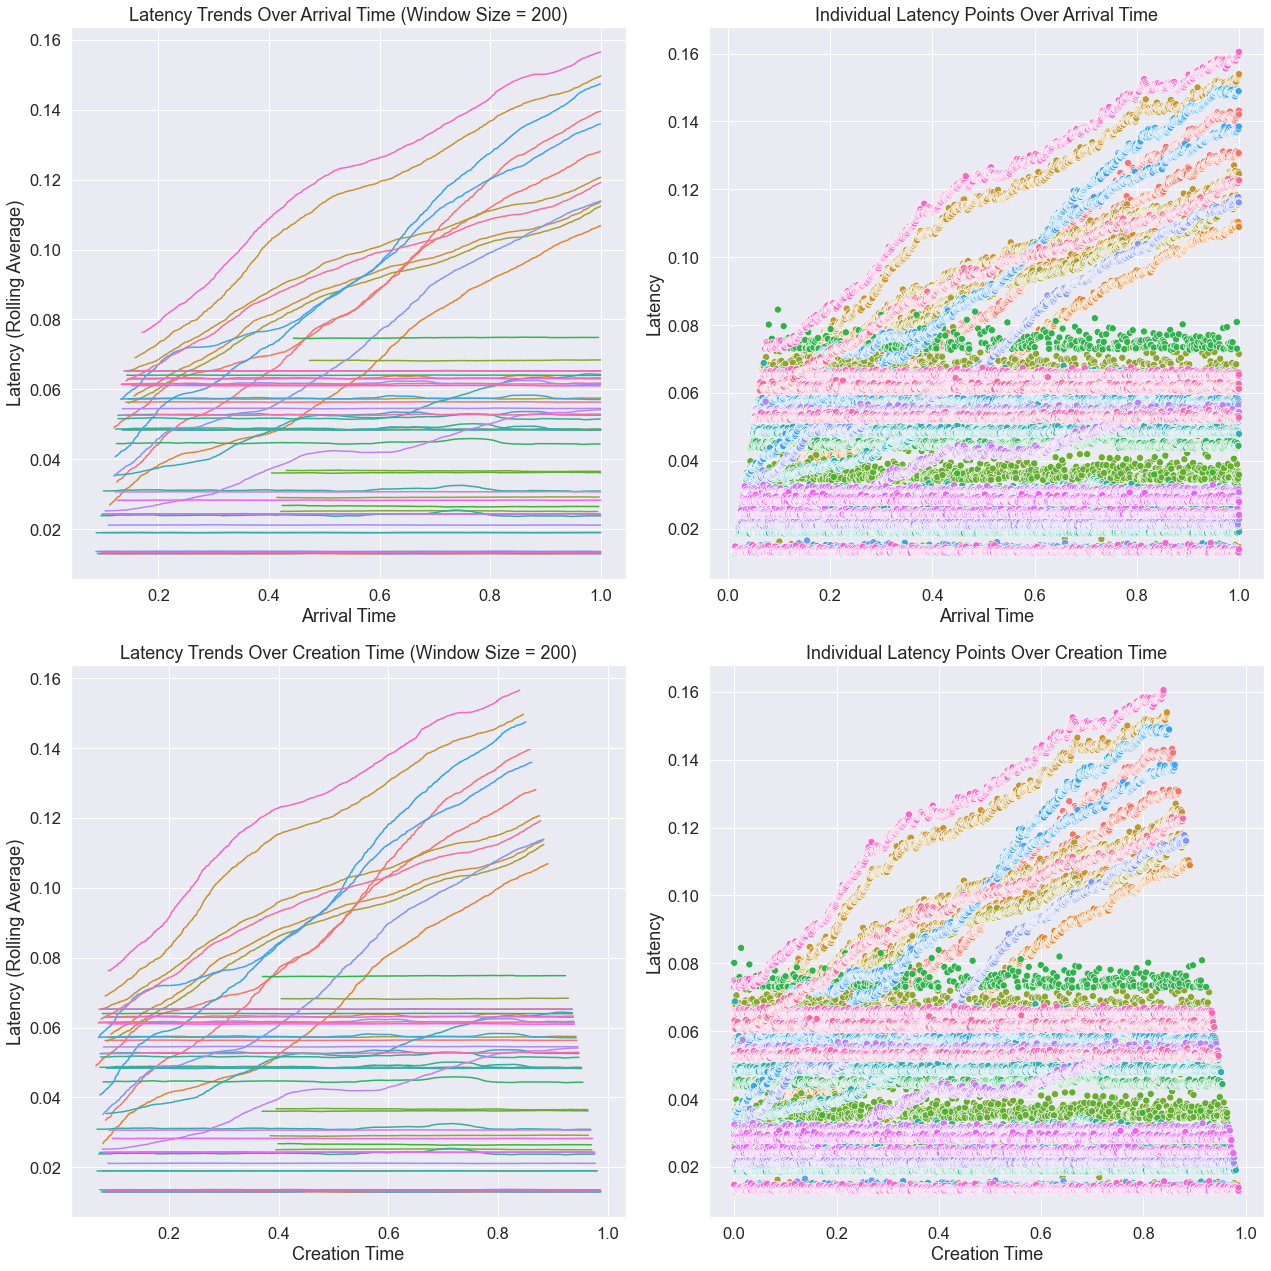

,Unnamed: 0,Creation Time,Latency,Arrival Time,Source,Destination,Block ID,Block Index
0,2037,0.000000,0.055835,0.055835,"Aalborg, Denmark","Cordoba, Argentina (partner station)",2_3_0,0
1,2099,0.000049,0.056376,0.056425,"Aalborg, Denmark","Cordoba, Argentina (partner station)",2_3_1,1
2,2190,0.000597,0.056833,0.057430,"Aalborg, Denmark","Cordoba, Argentina (partner station)",2_3_2,2
3,2199,0.001584,0.055933,0.057517,"Aalborg, Denmark","Cordoba, Argentina (partner station)",2_3_3,3
4,2203,0.001626,0.055939,0.057565,"Aalborg, Denmark","Cordoba, Argentina (partner station)",2_3_4,4
...,...,...,...,...,...,...,...,...
118936,118825,0.876322,0.122711,0.999033,"Tolhuin, Argentina (partner station)","Nuuk, Greenland",4_7_2376,2376
118937,118879,0.876674,0.122796,0.999470,"Tolhuin, Argentina (partner station)","Nuuk, Greenland",4_7_2377,2377
118938,118893,0.877164,0.122417,0.999581,"Tolhuin, Argentina (partner station)","Nuuk, Greenland",4_7_2378,2378
118939,118915,0.877266,0.122495,0.999761,"Tolhuin, Argentina (partner station)","Nuuk, Greenland",4_7_2379,2379


In [6]:
# Read the newly uploaded CSV file into a raw DataFrame
source = './allLatencies_8_gatewaysSR'
df_raw = pd.read_csv(source + '.csv')

# remove aalborg
# df_raw = df_raw[(df_raw['Source'] != 'Aalborg, Denmark') & (df_raw['Destination'] != 'Aalborg, Denmark')]

# Extract the data block index from the Block ID in the raw DataFrame
df_raw['Block Index'] = df_raw['Block ID'].apply(extract_block_index)

# Sort the DataFrame by paths (Source and Destination)
df_sorted_by_paths_raw = df_raw.sort_values(by=['Source', 'Destination', 'Block Index'])

# Test the updated function on the raw DataFrame with a window size of 20
create_latency_plots(df_sorted_by_paths_raw, window_size=200)

df_raw


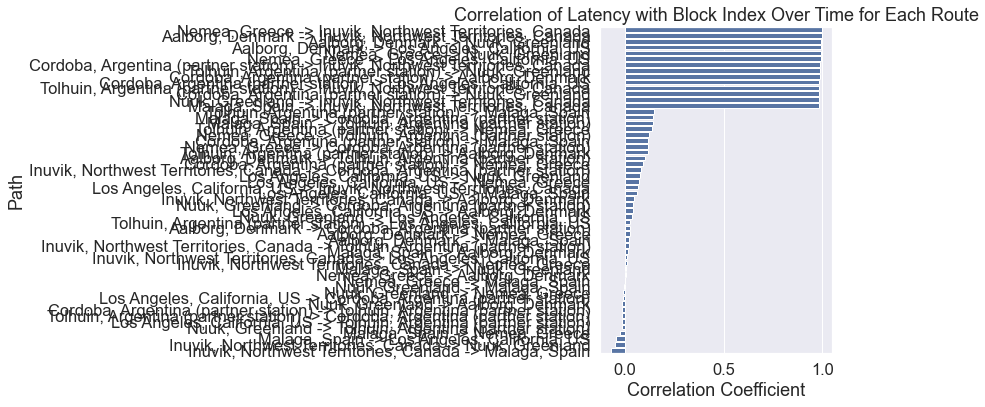

,Unnamed: 0,Creation Time,Latency,Arrival Time,Source,Destination,Block ID,Block Index
0,2037,0.000000,0.055835,0.055835,"Aalborg, Denmark","Cordoba, Argentina (partner station)",2_3_0,0
1,2099,0.000049,0.056376,0.056425,"Aalborg, Denmark","Cordoba, Argentina (partner station)",2_3_1,1
2,2190,0.000597,0.056833,0.057430,"Aalborg, Denmark","Cordoba, Argentina (partner station)",2_3_2,2
3,2199,0.001584,0.055933,0.057517,"Aalborg, Denmark","Cordoba, Argentina (partner station)",2_3_3,3
4,2203,0.001626,0.055939,0.057565,"Aalborg, Denmark","Cordoba, Argentina (partner station)",2_3_4,4
...,...,...,...,...,...,...,...,...
118936,118825,0.876322,0.122711,0.999033,"Tolhuin, Argentina (partner station)","Nuuk, Greenland",4_7_2376,2376
118937,118879,0.876674,0.122796,0.999470,"Tolhuin, Argentina (partner station)","Nuuk, Greenland",4_7_2377,2377
118938,118893,0.877164,0.122417,0.999581,"Tolhuin, Argentina (partner station)","Nuuk, Greenland",4_7_2378,2378
118939,118915,0.877266,0.122495,0.999761,"Tolhuin, Argentina (partner station)","Nuuk, Greenland",4_7_2379,2379


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def extract_block_index(block_id):
    return int(block_id.split('_')[-1])

def create_correlation_plot(df, metric='Creation Time'):
    sns.set(font_scale=1.5)
    df['Path'] = df['Source'].astype(str) + ' -> ' + df['Destination'].astype(str)
    
    # Calculate the correlation of 'Latency' with the chosen metric for each path
    path_correlations = df.groupby('Path').apply(lambda x: x['Latency'].corr(x[metric]))
    
    # Create a new DataFrame for plotting
    correlation_df = path_correlations.reset_index(name='Correlation')
    
    # Create a bar plot to visualize the correlation for each path
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Correlation', y='Path', data=correlation_df.sort_values('Correlation', ascending=False))
    plt.title(f'Correlation of Latency with {metric} Over Time for Each Route')
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Path')
    plt.tight_layout()
    plt.show()
    sns.set(font_scale=1.0)

# Read the CSV file into a DataFrame
source = './allLatencies_8_gatewaysSR'
df_raw = pd.read_csv(source + '.csv')

# Optionally remove a location, if required
# df_raw = df_raw[(df_raw['Source'] != 'Aalborg, Denmark') & (df_raw['Destination'] != 'Aalborg, Denmark')]

# Extract the block index from the Block ID
df_raw['Block Index'] = df_raw['Block ID'].apply(extract_block_index)

# Sort the DataFrame by paths (Source and Destination)
df_sorted = df_raw.sort_values(by=['Source', 'Destination', 'Block Index'])

# Call the function to create the latency plots
# create_latency_plots(df_sorted, window_size=200)

# Call the function to create the correlation plot
create_correlation_plot(df_sorted, metric='Block Index')

# Display the raw DataFrame
df_raw


In [7]:
!dir

 El volumen de la unidad T es DATOS
 El n�mero de serie del volumen es: 6648-9550

 Directorio de t:\Fede\SatNEx_code\tests

17/10/2023  10:17    <DIR>          .
17/10/2023  10:17    <DIR>          ..
09/10/2023  17:39             5.684 allLatencies_2gateways.csv
13/10/2023  03:59         1.806.350 allLatencies_3_gateways.csv
17/10/2023  10:19            15.309 becaria.ipynb
10/10/2023  14:41               124 logfile.log
               4 archivos      1.827.467 bytes
               2 dirs  168.024.330.240 bytes libres
